In [1]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

from konlpy.tag import Okt

import matplotlib.pyplot as plt

In [2]:
# 경로 이동
os.chdir(r'./\ICT해커톤\챗봇\데이터')

In [3]:
# 사전 정의

PAD = "<PADDING>"
PAD_INDEX = 0
OOV = "<OOV>"
OOV_INDEX = 1

VOCAB_SIZE = 0 # 후에 len(words) 로 바뀜.
CATEGORY = 0 # 후에 category 갯수만큼 바꿈
# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 30



In [4]:
# 형태소분석 함수
def pos_tag(sentences):
    
    # KoNLPy 형태소분석기 설정
    tagger = Okt()
    
    # 문장 품사 변수 초기화
    sentences_pos = []
    
    # 인풋이 리스트면
    if isinstance(sentences,list):
    # 모든 문장 반복
        for sentence in sentences:
            # [\"':;~()] 특수기호 제거
            sentence = re.sub("[ㄱ-ㅎㅏ-ㅣ-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", " ", sentence)
            
            
            # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
            sentence = " ".join(tagger.morphs(sentence))
            sentences_pos.append(sentence)
            
    # str이면        
    elif isinstance(sentences, str):
        sentences=re.sub("[ㄱ-ㅎㅏ-ㅣ-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", " ", sentences)
        sentences_pos= " ".join(tagger.morphs(sentences))
        
    return sentences_pos

In [5]:
def convert_text_to_index_for_classification(sentences, vocabulary): 
    sentences_index = []
    if isinstance(sentences,list):
        # 모든 문장에 대해서 반복
        for sentence in sentences:
            sentence_index = []

            # 문장의 단어들을 띄어쓰기로 분리
            for word in sentence.split():
                if vocabulary.get(word) is not None:
                    # 사전에 있는 단어면 해당 인덱스를 추가
                    sentence_index.extend([vocabulary[word]])
                else:
                    # 사전에 없는 단어면 OOV 인덱스를 추가
                    sentence_index.extend([vocabulary[OOV]])

            if len(sentence_index) > max_sequences:
                sentence_index = sentence_index[:max_sequences]

            # 최대 길이에 없는 공간은 패딩 인덱스로 채움
            sentence_index += (max_sequences - len(sentence_index)) * [vocabulary[PAD]]

            # 문장의 인덱스 배열을 추가
            sentences_index.append(sentence_index)
    elif isinstance(sentences, str):
        sentence_index = []
        for word in sentences.split():
            if vocabulary.get(word) is not None:
                # 사전에 있는 단어면 해당 인덱스를 추가
                sentence_index.extend([vocabulary[word]])
            else:
                # 사전에 없는 단어면 OOV 인덱스를 추가
                sentence_index.extend([vocabulary[OOV]])

        if len(sentence_index) > max_sequences:
            sentence_index = sentence_index[:max_sequences]

        # 최대 길이에 없는 공간은 패딩 인덱스로 채움
        sentence_index += (max_sequences - len(sentence_index)) * [vocabulary[PAD]]

        sentences_index.append(sentence_index)
    return sentences_index

4

In [19]:
df_main = pd.read_csv('sentences.csv',encoding='utf-8')
print(df_main.head())
a=df_main['Emotion'].unique()
category =list(a)
CATEGORY = len(category)

# 분노 0,슬픔 1, 중립 2, 행복 3,
# 카테고리 인덱스

category_to_index = {word: index for index, word in enumerate(category)}

index_to_category = {index: word for index, word in enumerate(category)}


                      Sentence Emotion
0  서해 수자원도 한류라서 그동안 불법조업 방치했나?      분노
1                     니가 인간이가.      분노
2    강아지를 때리고 유기하는것만 학대는 아닙니다!      분노
3        하여간 우리나라 교육엔 미래가 없어!!      분노
4     채널에이 군부 개인거 인증하냐 동아일보야!!      분노


In [20]:
words = []
ori_sentence =[]
# 데이터 프레임 list화
for i in range(len(df_main)):
    tmp =[]
    tmp.append(str(i+1))
    tmp.append(df_main.iloc[i].Sentence)
    tmp.append(df_main.iloc[i].Emotion)
    ori_sentence.append(tmp)
    
# 문장 형태소 분석 및 전처리
sente=[]
for i in ori_sentence:
    sente.append(i[1])

senten = pos_tag(sente)

# 단어들의 배열 생성
for sentence in senten:
    for word in sentence.split():
        words.append(word)

# 길이가 0인 단어는 삭제
words = [word for word in words if len(word) > 0]

# 중복된 단어 삭제
words = list(set(words))

# 제일 앞에 태그 단어 삽입
words[:0] = [PAD, OOV]

VOCAB_SIZE = len(words)
print(VOCAB_SIZE)

57280


In [21]:
max_length = max(len(l) for l in senten)
avg_length = sum(map(len, senten))/len(senten)
print('리뷰의 최대 길이 : {}'.format(max_length))
print('리뷰의 평균 길이 : {}'.format(avg_length))
max_sequences= int(avg_length) + 15

리뷰의 최대 길이 : 299
리뷰의 평균 길이 : 26.664841617003788


In [22]:
# 단어와 인덱스의 딕셔너리 생성
word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}

# model train

In [26]:
# 모델인풋
sentence_index_for_cl = []
sentence_index_for_cl = convert_text_to_index_for_classification(senten, word_to_index) #질문 문장에 정수인코딩,패딩
print(len(sentence_index_for_cl))

68126


In [24]:
# label 데이터 정수화
label=[]
for i,item in enumerate(ori_sentence):
    label.append(category_to_index[item[2]])
    
print(len(label))
label[:3]

68126


[0, 0, 0]

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Masking, Bidirectional

#카테고리 분류모델
cmodel = Sequential()
cmodel.add(Embedding(VOCAB_SIZE, 100))
cmodel.add(Masking(mask_value=0.0))
cmodel.add(Bidirectional(LSTM(128)))
cmodel.add(Dense(CATEGORY, activation='softmax'))

In [28]:
# input shape

print(np.asarray(sentence_index_for_cl).shape)
print(np.asarray(label).shape)

(68126, 41)
(68126,)


In [54]:
cmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_c = cmodel.fit(np.asarray(sentence_index_for_cl), np.asarray(label), validation_split=0.1, batch_size=64, epochs=3)

Epoch 1/3
959/959 [==============================] - 90s 94ms/step - loss: 0.0500 - acc: 0.9821 - val_loss: 1.8538 - val_acc: 0.6772
Epoch 2/3
959/959 [==============================] - 95s 99ms/step - loss: 0.0368 - acc: 0.9866 - val_loss: 1.7863 - val_acc: 0.7157
Epoch 3/3
959/959 [==============================] - 96s 100ms/step - loss: 0.0303 - acc: 0.9890 - val_loss: 1.9530 - val_acc: 0.7251


In [55]:
# 모델 저장
cmodel.save('main_lstm_cl.h5')

In [56]:
# 모델 불러오기
load_c_model = models.load_model('main_lstm_cl.h5')

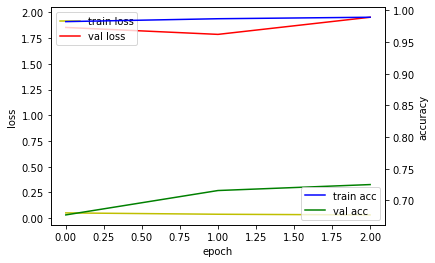

In [57]:
# 결과 시각화

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history_c.history['loss'], 'y', label='train loss')
loss_ax.plot(history_c.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history_c.history['acc'], 'b', label='train acc')
acc_ax.plot(history_c.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower right')

plt.show()

# predict

In [59]:
def predict_emotion(text):
    pre_text = pos_tag(text)
    pre_x=convert_text_to_index_for_classification(pre_text, word_to_index)
    result=np.argmax(load_c_model.predict(np.asarray(pre_x).reshape(1,max_sequences)))
    return index_to_category[result]

In [61]:
predict_text=input('문장을 입력해주세요')
print(predict_emotion(predict_text))


문장을 입력해주세요짜증나게 하네요
분노
